Building on the tutorial at https://pyro.ai/examples/sir_hmc.html, the folks at Pyro created an additional interface for SIR modeling that compresses much of the info that that tutorial provided into a concrete interface for compartmental modeling. Below is that work, drawn from http://pyro.ai/examples/epi_intro.html

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [2]:
pyro.__version__

'1.5.0'

In [10]:
ros = []
for i in range(1000):
    R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
    ros.append(R0.item())

(array([935.,  53.,   7.,   1.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([2.93749378e-02, 4.54523334e+00, 9.06109173e+00, 1.35769501e+01,
        1.80928085e+01, 2.26086669e+01, 2.71245253e+01, 3.16403837e+01,
        3.61562421e+01, 4.06721005e+01, 4.51879589e+01]),
 <BarContainer object of 10 artists>)

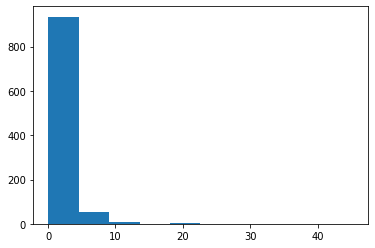

In [12]:
plt.hist(ros)

Word. This is what it expects R0 to be, most likely btw 0 and 1. Is updated accordingly!

In [13]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        """
        samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). 
        The return value is available as the params argument to the other two methods.
        """
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        """
        samples (or deterministically sets) initial values of time series,
        returning a dictionary mapping time series name to initial value.
        """
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        """
        inputs global params, the state at the previous time step, and the time index t (which may be a slice!). 
        It then samples flows and updates the state dict.
        """
        R0, tau, rho = params # R0 

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

## Generating Data

What if I don't want to do this? 

In [15]:
population = 10000
recovery_time = 10.
empty_data = [None] * 300
model = SimpleSIRModel(population, recovery_time, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 1.7})
    total_infections = synth_data["S2I"].sum().item()
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


Simulated 4382.0 infections after 9 attempts


In [81]:
synth_data

OrderedDict([('R0', tensor(1.7000)),
             ('rho', tensor(0.4613)),
             ('I2R',
              tensor([0.0000e+00, 3.2000e+01, 5.2000e+01, 8.9000e+01, 1.1200e+02, 1.3600e+02,
                      1.5800e+02, 1.6100e+02, 2.0100e+02, 2.0000e+02, 2.2000e+02, 2.2800e+02,
                      2.4800e+02, 2.7100e+02, 2.9200e+02, 3.2400e+02, 3.4100e+02, 3.2600e+02,
                      3.4000e+02, 3.6300e+02, 4.1100e+02, 4.4100e+02, 4.8200e+02, 4.9500e+02,
                      5.0700e+02, 5.8500e+02, 6.4200e+02, 6.6300e+02, 7.5300e+02, 7.6900e+02,
                      8.8800e+02, 8.9600e+02, 9.6300e+02, 1.0250e+03, 1.1000e+03, 1.1380e+03,
                      1.2990e+03, 1.2710e+03, 1.4810e+03, 1.5530e+03, 1.6560e+03, 1.7820e+03,
                      1.8440e+03, 2.0230e+03, 2.1060e+03, 2.2170e+03, 2.4300e+03, 2.7100e+03,
                      2.7270e+03, 2.9430e+03, 3.2180e+03, 3.4400e+03, 3.7220e+03, 3.8580e+03,
                      4.2090e+03, 4.5580e+03, 4.8580e+03, 

For the model to work, it requires S, S2I, I, I2R, obs (noisy S2I), R0, and rho. 


At the moment, all of these things are synthetically generated, after we first specify R0, rho and population. 

For real world, I'll try this now, but we set:

S2I = obs, and use reported values for the others. In essence we no longer use the noisy observations and assume whatever is reported is right? 

I'm not sure if the model will work if we do not specify R0 or rho, so will have to try this and find out. 

In [16]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))
    

I.shape = (300,)
I2R.shape = (300,)
R0.shape = ()
S.shape = (300,)
S2I.shape = (300,)
obs.shape = (300,)
rho.shape = ()


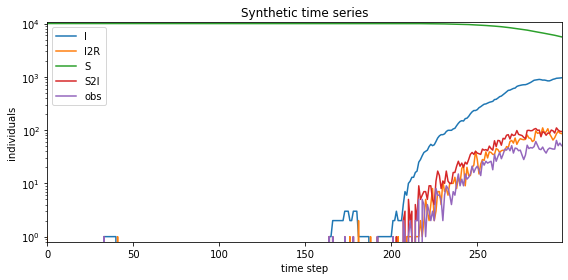

In [17]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

## Inference

In [18]:
# what if we only have obs? can we estimate using just that? 
obs = synth_data["obs"]
model = SimpleSIRModel(population, recovery_time, obs) 


In [19]:
%%time
losses = model.fit_svi(num_steps=101 if smoke_test else 2001,
                       jit=True)

INFO 	 Heuristic init: R0=1.58, rho=0.495
INFO 	 Running inference...
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
INFO 	 step 0 loss = 11.01
INFO 	 step 200 loss = 6.49
INFO 	 step 400 loss = 3.925
INFO 	 step 600 loss = 2.709
INFO 	 step 800 loss = 2.011
INFO 	 step 1000 loss = 1.802
INFO 	 step 1200 loss = 1.73
INFO 	 step 1400 loss = 1.708
INFO 	 step 1600 loss = 1.684
INFO 	 step 1800 loss = 1.678
INFO 	 step 2000 loss = 1.657
INFO 	 SVI took 30.9 seconds, 64.7 step/sec


CPU times: user 32.6 s, sys: 96.1 ms, total: 32.7 s
Wall time: 34 s


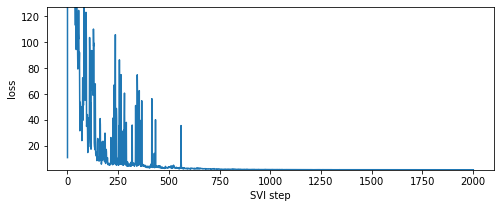

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.ylim(min(losses), max(losses[50:]));

In [21]:
for key, value in sorted(model.samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

R0.shape = (100, 1)
auxiliary.shape = (100, 1, 2, 300)
rho.shape = (100, 1)


## MCMC

In [26]:
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 800,
                      jit_compile=True,)

INFO 	 Running inference...
Sample: 100%|██████████| 1600/1600 [02:51,  9.33it/s, step size=1.66e-02, acc. prob=0.766]


## Prediction

In [27]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 595 ms, sys: 14.9 ms, total: 610 ms
Wall time: 631 ms


In [28]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (800, 300)
I2R.shape = (800, 300)
R0.shape = (800, 1)
S.shape = (800, 300)
S2I.shape = (800, 300)
auxiliary.shape = (800, 1, 2, 300)
obs.shape = (800, 300)
rho.shape = (800, 1)


/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


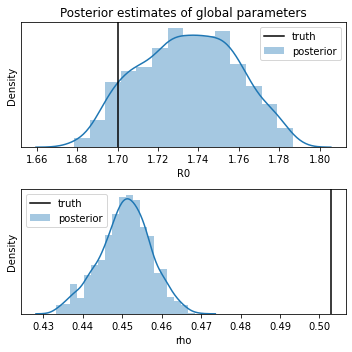

In [29]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


## Forecasting

In [30]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


INFO 	 Forecasting 30 steps ahead...


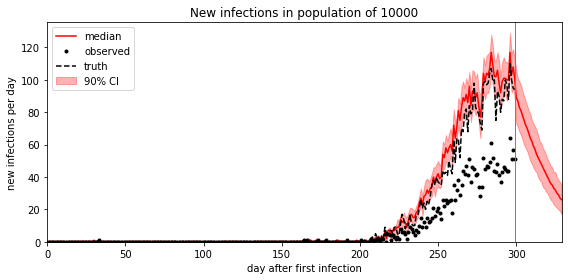

In [31]:

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2I"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)

A suggestion of the authors is to use MCMC rather than SVI to estimate, and this will produce better results with only a little longer compute time. I will avoid doing that for the moment, because I would consider it a higher priority to figure out how to run this model with actual data, rather than manufactured. 

Bigger picture:

We don't really need to use MCMC do we? We are more interested in the generate data aspect, and seeing how intervention affects outcome. One way to apply MCMC I guess is we have our pandemic generate data function, leave R0 as the initial value, but implement countermeasures and generate data again. Using Inference we can determine what this new R0 is, and indicate how much better this would be. 